In [14]:
import numpy as np
import pandas as pd
import pynapple as nap
from pathlib import Path
from scipy.stats import zscore
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
mouse = 29
day = 23
session_type = 'VR'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/nwb_data/')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)

if session_type == 'VR':
    tl = 200
elif session_type == 'MCVR':
    tl = 230
bin_config = get_bin_config(session_type)['P']



first position: 100.28862953186035
this mouse started on trial number 72
this mouse ended on trial number 220
this completed experienced 149.0 trials
each trial equates to 200 cm
this mouse travelled 297.6125148773193 meters
we will use a bin size of 2 cm and 14900 bins


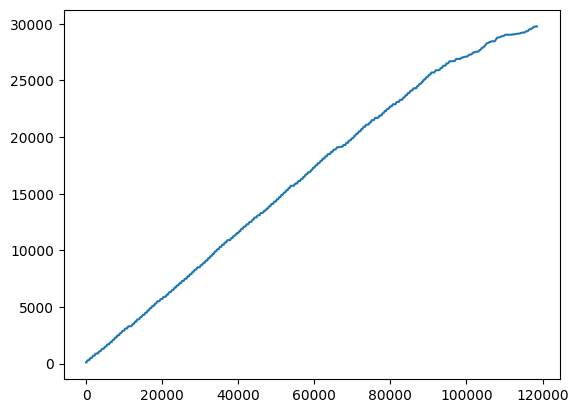

In [22]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
ramp_scores = tuning_scores['ramp_class']

bin_size_cm = 2
positions = np.array(session['P'])
times = np.array(session['P'].index)
trial_numbers = np.array(session['trial_number'])
distance_travelled = positions+(tl*(trial_numbers-1))
distance_travelled_adjusted = distance_travelled-((trial_numbers[0]-1)*tl)
n_bins = int(int(((np.ceil(np.nanmax(distance_travelled_adjusted))//tl)+1)*tl)/bin_size_cm)
max_bound = int(((np.ceil(np.nanmax(distance_travelled_adjusted))//tl)+1)*tl)
min_bound = 0
tmp_TSD = nap.TsdFrame(t=times, d=distance_travelled_adjusted, columns=['dt'])


print(f'first position: {positions[0]}')
print(f'this mouse started on trial number {int(np.min(trial_numbers))}')
print(f'this mouse ended on trial number {int(np.max(trial_numbers))}')
print(f'this completed experienced {np.max(trial_numbers)-np.min(trial_numbers)+1} trials')
print(f'each trial equates to {tl} cm')
print(f'this mouse travelled {np.nanmax(distance_travelled_adjusted)/100} meters')
print(f'we will use a bin size of {bin_size_cm} cm and {n_bins} bins')
plt.plot(distance_travelled_adjusted)
plt.show()


In [ ]:
tcs = {}
for index in neurons.index:
    this_neuron = neurons[neurons.index == index]
    tc = nap.compute_1d_tuning_curves(this_neuron, 
                                      tmp_TSD["dt"], 
                                      nb_bins=n_bins, 
                                      minmax=[min_bound, max_bound])[index]
    mask = np.isnan(tc)
    tc2 = gaussian_filter(np.nan_to_num(tc).astype(np.float64), sigma=bin_config['smooth_sigma'])
    tc3 = zscore(tc2)
    tcs[index] = tc3



In [ ]:
from sklearn.linear_model import LinearRegression

x_true_dt = tc.index
x_true_p = x_true_dt%tl
x_true_p_scaled = (x_true_p/tl) * 2 * np.pi -np.pi
rates = np.vstack(list(tcs.values())).T

# Circular-linear coordinates
cos_x = np.cos(x_true_p_scaled)
sin_x = np.sin(x_true_p_scaled)

# Train-test split
train_size = len(x_true_p) // 2
rates_train, rates_test = rates[:train_size], rates[train_size:]
cos_x_train, cos_x_test = cos_x[:train_size], cos_x[train_size:]
sin_x_train, sin_x_test = sin_x[:train_size], sin_x[train_size:]

# Train the decoder
reg_cos = LinearRegression().fit(rates_train, cos_x_train)
reg_sin = LinearRegression().fit(rates_train, sin_x_train)

# Predict positions
cos_x_pred = reg_cos.predict(rates_test)
sin_x_pred = reg_sin.predict(rates_test)

# Decode positions
angles = np.arctan2(sin_x_pred, cos_x_pred)
x_pred = (angles + np.pi) / (2 * np.pi) * tl

# Evaluate the decoder
error_rad = np.mean(np.abs(angles - x_true_p_scaled[train_size:]))
error_cm = error_rad / (2 * np.pi) * tl
print(f'Mean absolute error: {error_rad:.2f}')
print(f'Mean absolute error: {error_cm:.2f}')

# Convert the predictions back to position units
x_pred_p = (angles + np.pi) / (2 * np.pi) * 200


Mean absolute error: 0.63
Mean absolute error: 20.11


idx ranges from 0 to 7450


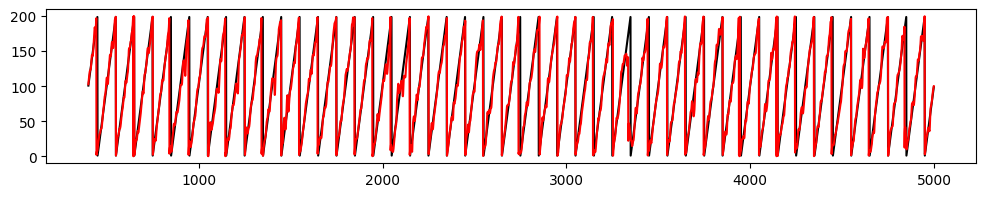

In [66]:
print(f'idx ranges from {0} to {train_size}')
start_idx = 400
end_idx = 5000
fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(train_size)[start_idx:end_idx], x_true_p[train_size:][start_idx:end_idx], color='black')
ax.plot(np.arange(train_size)[start_idx:end_idx], x_pred[start_idx:end_idx], color='red')
plt.show()
